# Movie Sentiment Analysis: Review Polarity Classification

## Background

This project focuses on sentiment analysis of movie reviews, aimed at determining the underlying sentiment expressed within a body of text. By analyzing the content of movie reviews, we strive to classify each review as positive or negative automatically. 

Dataset can be found in [here](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).


## **Plan**

### 1.1 Plan

We need to perform data cleaning and use Multilayer Perceptrons (MLP) to build a model, and we will use the model we build to predict our text.

## **Analyze**

### 2.1 Import, Load and Examine 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from bs4 import BeautifulSoup
import string
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### 2.2 Data Cleaning

- **HTML tags:** If dataset contain HTML tags that we will need to remove it.
- **Special characters and numbers:** Special characters and numbers do not contribute to sentiment analysis and can be removed.
- **Punctuation:** Punctuation marks can be removed, depends on different approach.
- **Lowercase** all sentences to make sure they look same in our model.
- **Missing data** Missing data row should be delete.

#### 2.2.1 Remove HTML Tags


In [4]:
# Remove HTML tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Apply function to dataset
df["review"] = df["review"].apply(remove_html_tags)

#### 2.2.2 Remove Special Characters & Numbers

In [5]:
# Remove pecial characters and numbers
df["review"] = df["review"].str.replace("[^a-zA-Z]", " ", regex=True)

# Remove extra spaces
df["review"] = df["review"].str.replace("\s+", " ", regex=True).str.strip()

#### 2.2.3 Remove Punctuation

In [6]:
# Remove punctuation
punctuation_pattern = f"[{string.punctuation}]"
df["review"] = df["review"].str.replace(punctuation_pattern, "", regex=True)

#### 2.2.4 Lowercase

In [7]:
# Lowercase
df["review"] = df["review"].str.lower()

#### 2.2.5 Missing Value

In [8]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

### 2.3 Data Processing

#### 2.3.1 Tokenization

In [9]:
# Tokenization
df["review"] = df["review"].apply(word_tokenize)

#### 2.3.2 Remove Stop Words

In [10]:
# Remove stop words
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def remove_stop_words(token_list):
    return [word for word in token_list if word not in stop_words]

df["review"] = df["review"].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 2.3.3 Lemmatization / Stemming

Choosing Between Lemmatization and Stemming
- **Lemmatization** is generally more sophisticated and produces more grammatically correct results (actual words), but it's computationally more intensive.
- **Stemming** is faster but may produce results that are not actual words (e.g., "runn" for "running").

These processes help in reducing the number of unique tokens in the model needs to learn about.

In [11]:
# Stemming
def stem_tokens(token_list):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in token_list]

df["review"] = df["review"].apply(stem_tokens)

### 2.3 Extract High-Frequency Words

In [12]:
# Extract high-frequency words
all_tokens = [token for sublist in df["review"] for token in sublist]
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)
most_common_words

[('movi', 103241),
 ('film', 95853),
 ('one', 55435),
 ('like', 45197),
 ('time', 31953),
 ('good', 30179),
 ('make', 30020),
 ('charact', 28347),
 ('see', 28235),
 ('get', 27963),
 ('watch', 27873),
 ('even', 25347),
 ('stori', 25272),
 ('would', 24599),
 ('realli', 23090),
 ('well', 21784),
 ('scene', 21434),
 ('look', 19945),
 ('show', 19913),
 ('much', 19316)]

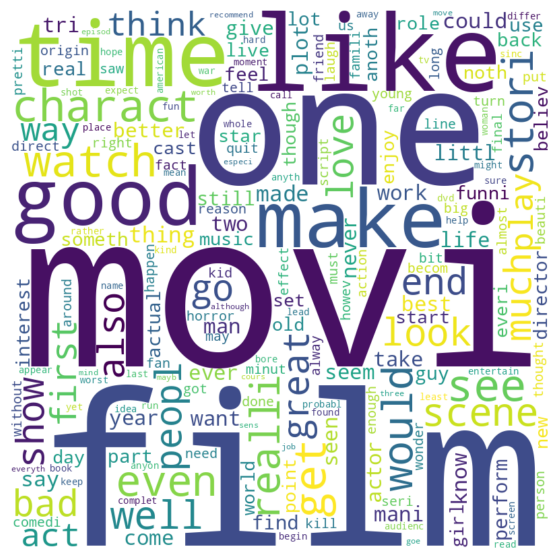

In [13]:
# Visualize it using wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide the axes
plt.show()

### 2.4 Text Vectorization

**TF-IDF**

In [14]:
# Join the tokens back into strings for the vectorizer
df["joined_review"] = df["review"].apply(" ".join)
text_data = df["joined_review"]
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

# Fit the vectorizer to the text data and transform it into TF-IDF features
x_tfidf = tfidf_vectorizer.fit_transform(text_data)
x_tfidf


<50000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 3571126 stored elements in Compressed Sparse Row format>

## **Construct**

We will build model use **Multilayer Perceptron (MLP)**.

### 3.1 Split Dataset

In [15]:
# Converting categorical labels to numerical form

df["sentiment_numeric"] = df["sentiment"].map({"positive": 1, "negative": 0})

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df["sentiment_numeric"], test_size=0.2, random_state=1)

### 3.2 Model Initialization and Training

In [16]:
# Scale data
scaler = MaxAbsScaler()

# Scale the training and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [17]:
# Train MLP model
mlp_model = MLPClassifier()
mlp_model.fit(x_train_scaled, y_train)

MLPClassifier()

In [18]:
# Evaluate the Model
y_pred = mlp_model.predict(x_test_scaled)

# Calculate accuracy
mlp_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {mlp_accuracy}")

# Print classification report for a detailed performance analysis
print(classification_report(y_test, y_pred))

Model accuracy: 0.8758
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5044
           1       0.87      0.89      0.88      4956

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Due to the extensive computational resources and time required for hyperparameter tuning, I am unable to proceed with this step. Nonetheless, using the default parameters, we have achieved an accuracy of 87%, and we will consider this satisfactory for our current purposes.

### 3.3 Evaluate Model

#### 3.3.1 Confusion Matrix

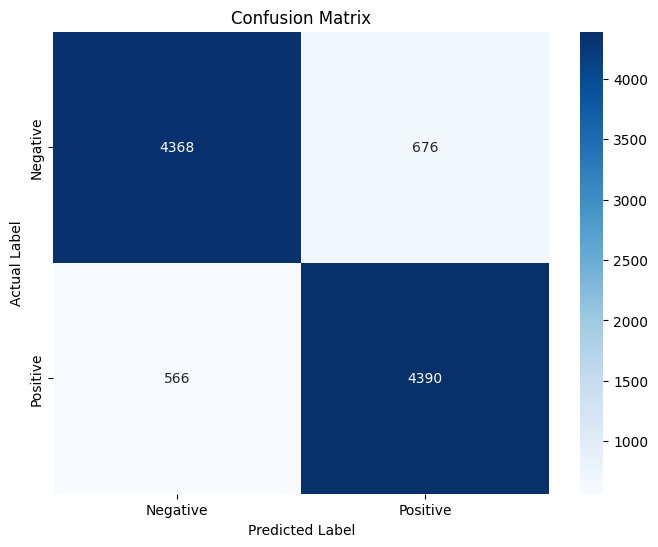

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


#### 3.3.2 Scores

In [20]:
# Define a function to get all scores
def get_scores(y_true, y_pred_prob, threshold=0.5):

    y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)
    
    scores = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Roc_Auc': roc_auc_score(y_true, y_pred_prob[:, 1])
    }
    
    return scores

y_pred_mlp_prob = mlp_model.predict_proba(x_test_scaled)

# Now call the function with the true labels and the predicted probabilities
scores_mlp = get_scores(y_test, y_pred_mlp_prob)
scores_mlp


{'Accuracy': 0.8758,
 'Precision': 0.8665613896565337,
 'Recall': 0.8857949959644875,
 'F1': 0.8760726401915785,
 'Roc_Auc': 0.9485872986004036}

## **Execute**

### 4.1 Make New Prediction

In [21]:
# Sample text to predict sentiment
sample_text = [
    "This movie was a great watch with brilliant performances and a gripping plot!",  # Positive
    "An absolute waste of time, the worst movie I've seen in a long while.",  # Negative
    "I found the movie to be mediocre, not terrible but not great either.",  # Neutral
    "The cinematography was stunning, but the storyline was lacking and unoriginal.",  # Neutral/Negative
    "The film was a masterpiece with a perfect blend of drama and action, a must-watch!",  # Positive
    "It was an okay movie; I neither liked it nor disliked it particularly.",  # Neutral
    "The plot twist at the end was predictable and uninspired.",  # Negative
    "A stellar cast, but the film fell flat due to poor writing.",  # Negative
    "I loved the special effects, but the characters were not very compelling.",  # Neutral/Negative
    "The movie was well-received by critics but I didn't find it very interesting.",  # Neutral
    "This film is overrated, I had high expectations but was sadly disappointed.",  # Negative
    "What an entertaining experience, I was on the edge of my seat the whole time!"  # Positive
]

for text in sample_text:
    # Convert the text to TF-IDF features
    sample_tfidf = tfidf_vectorizer.transform([text])

    # Scale the features because we scaled during training
    sample_scaled = scaler.transform(sample_tfidf)

    # Make a prediction
    prediction_prob = mlp_model.predict_proba(sample_scaled)

    # Get the predicted probability of the positive class
    positive_prob = prediction_prob[0, 1]

    # Apply threshold to convert probabilities to class labels
    prediction = 1 if positive_prob > 0.5 else 0

    # Output the prediction
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"{text} ->  {sentiment}")
    # print(f"Predicted sentiment: {sentiment}")

This movie was a great watch with brilliant performances and a gripping plot! ->  Positive
An absolute waste of time, the worst movie I've seen in a long while. ->  Negative
I found the movie to be mediocre, not terrible but not great either. ->  Positive
The cinematography was stunning, but the storyline was lacking and unoriginal. ->  Negative
The film was a masterpiece with a perfect blend of drama and action, a must-watch! ->  Positive
It was an okay movie; I neither liked it nor disliked it particularly. ->  Negative
The plot twist at the end was predictable and uninspired. ->  Positive
A stellar cast, but the film fell flat due to poor writing. ->  Negative
I loved the special effects, but the characters were not very compelling. ->  Positive
The movie was well-received by critics but I didn't find it very interesting. ->  Positive
This film is overrated, I had high expectations but was sadly disappointed. ->  Negative
What an entertaining experience, I was on the edge of my seat

### 4.2 Result & Conclusion

Our model achieved the following performance metrics:

- Accuracy: 0.8782
- Precision: 0.8683
- Recall: 0.8890
- F1 Score: 0.8786
- ROC AUC: 0.9477

These results indicate a strong overall performance. Given the constraints on GPU resources, we were unable to conduct hyperparameter tuning. However, it's plausible that with further optimization, we could see an improvement in these scores.